In [2]:
# importing pandas to load data
import pandas as pd
# Loading the cleaned data
data = pd.read_csv("cleaned_data_1.csv",index_col = 0)

## Data preprocessing

### Overview

In this section we are going to prepare the data for machine learning. The data have to be normalized to change the values of numerical columns ensuring they are of a common scale to prevent features with large values from dominating those with smaller values giving the features have the same influence on the measurement metric.

In [5]:
# coping the data
data_2 = data.copy()
# Dropping columns not necessary for modelling
data_2.drop(["id","construction_year",'funder',"installer","longitude","latitude"],
            axis = 1,inplace = True)
data_2.head()

,amount_tsh,gps_height,basin,region,population,permit,extraction_type_class,management_group,payment,quality_group,quantity,source_class,waterpoint_type,status_group
0,6000.0,1390,Lake Nyasa,Iringa,109,False,gravity,user-group,pay annually,good,enough,groundwater,communal standpipe,1
1,0.0,1399,Lake Victoria,Mara,280,True,gravity,user-group,never pay,good,insufficient,surface,communal standpipe,1
2,25.0,686,Pangani,Manyara,250,True,gravity,user-group,pay per bucket,good,enough,surface,communal standpipe multiple,1
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,True,submersible,user-group,never pay,good,dry,groundwater,communal standpipe multiple,0
4,0.0,0,Lake Victoria,Kagera,0,True,gravity,other,never pay,good,seasonal,surface,communal standpipe,1


In [179]:
# Importing libraries needed
# For Scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

We decided to split the data into testing and training set so that the machine learning algorithms can learn from the training set and evaluate its performance using the testing set.

In [180]:
# Determining the predictor variables
X = data_2.drop(["status_group"],axis = 1)

# Determining the target variables

y = data_2.status_group

# Splitting the data to training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.3,random_state =42)

In [181]:
# Checking the shape of the split data
print(f'X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'y_train has {y_train.shape[0]} rows')
print(f'y_test has {y_test.shape[0]} rows')

X_train has 38984 rows and 13 columns
X_test has 16708 rows and 13 columns
y_train has 38984 rows
y_test has 16708 rows


We decide to turn the categorical data into numerical data using pandas method for getting dummies since sklearn only processes numeric data.

In [182]:
# Converting categorical variable into dummy variables for X_train
X_train_cat = pd.get_dummies(X_train.select_dtypes(include = ["object"]))

# Converting categorical variable into dummy variables for X_test

X_test_cat = pd.get_dummies( X_test.select_dtypes(include = ["object"]))

In [183]:
# Concatenating Numerical values with dummy variables for X_train
X_train_2 = pd.concat([X_train.select_dtypes(exclude = ["object"]),X_train_cat,],axis = 1)

# Concatenating Numerical values with dummy variables for X_test
X_test_2 = pd.concat([X_test.select_dtypes(exclude = ["object"]),X_test_cat],axis = 1)

### Scaling data using StandardScaler

In [184]:
# scaling our data

# Instantiate StandardScaler

scaler = StandardScaler()

# Fit and transform X_train

X_train_scaled = scaler.fit_transform(X_train_2)

# Transform X_test

X_test_scaled = scaler.transform(X_test_2)

#### LabelEncoding
We used LabelEncoder to normalize our target variable.

In [185]:
# LabelEncoding the target variable

# Instantiate LabelEncoder
label_encoding = LabelEncoder()

# fit_transforming the y_train

y_train_2 = label_encoding.fit_transform(y_train)

# Transforming y_test

y_test_2 = label_encoding.transform(y_test)

In [186]:
# Checking the labelencoded values for y_train
y_train_series = pd.Series(y_train_2)
print(y_train.value_counts())
print("\n")
print(y_train_series.value_counts())

functional                 21223
non functional             15092
functional needs repair     2669
Name: status_group, dtype: int64


0    21223
2    15092
1     2669
dtype: int64


In [187]:
# Checking the labelencoded values for y_test
y_test_series = pd.Series(y_test_2)
print(y_test.value_counts())
print("\n")
print(y_test_series.value_counts())

functional                 9003
non functional             6497
functional needs repair    1208
Name: status_group, dtype: int64


0    9003
2    6497
1    1208
dtype: int64


For our target variable:

`0` represents `functional wells`
    
`2` represents `non functional wells`
    
`1` represents  ` functional needs repair`

#### SMOTE
The study dealt with class imbalance on the train data, by oversampling the minority class and undersampling majority

In [188]:
from imblearn.over_sampling import SMOTE
# Instantiating smote
smote = SMOTE()
# Fitting smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_2)

# Modeling

We want to determine the most suitable machine learning model that will effectively recognize patterns of the wells and give predictions. 

Models used: 

`Logistic regression`

`RandomForest`

`KNearestNeighbours`

`Xg boost`

In order to determine the best set of hyperparameters for our models, we will use GridSearchCV.

## `LogisticRegression`

In [189]:
# importing necessary library
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#### LogisticRegression baseline model

In [127]:
#instantiating logistic regression
logreg = LogisticRegression(random_state = 42,
                            multi_class ="multinomial",
                            class_weight = "balanced")

# Fitting logistic regression
logreg.fit(X_train_resampled, y_train_resampled)

# Predicting on training and test sets
log_training_preds = logreg.predict(X_train_resampled)
log_test_preds = logreg.predict(X_test_scaled)

# Accuracy of training and test sets
log_training_accuracy = accuracy_score(y_train_resampled, log_training_preds)
log_test_accuracy = accuracy_score(y_test_2, log_test_preds)

print('Training Accuracy: {:.4}%'.format(log_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(log_test_accuracy * 100))

Training Accuracy: 62.55%
Validation accuracy: 60.88%


The training and validation accuracy scores are close to each other implying very minimal overfitting.

This accuracy does not meet our target thus we use hyperparameter tuning to see if the accuracy will improve

This model

In [64]:
# Creating a parameter grid for logistiv regression
param_grid = [{'penalty' : ['l1', 'l2'],
               'C' : np.logspace(-1, 1, 5),
               'solver' : ['lbfgs','newton-cg']}]

In [65]:
# Create a GridSearchCv
logreg_clf = GridSearchCV(estimator = logreg,
                          param_grid = param_grid,
                          cv = 3, verbose=True, n_jobs=-1)

In [190]:
# Fitting using grid search
best_clf = logreg_clf.fit(X_train_resampled,y_train_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [67]:
# Getting the best hyperparameters for our logistic regression 
best_clf.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

### Tuned LogisticRegression model

In [191]:
# Instantiating logistic regression model using the best parameters from the grid search
best_logreg = LogisticRegression(random_state = 42,multi_class ="multinomial",
                                 class_weight = "balanced",
                                 C = 0.1,penalty = "l2",
                                solver = "lbfgs")

In [193]:
# Fitting the model
best_logreg.fit(X_train_resampled,y_train_resampled)

LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',
                   random_state=42)

#### Evaluating LogisticRegression model

In [195]:
# Function that makes y predicted values
def make_preds(model, split):
    """ A function that makes predictions"""
    prediction = model.predict(split)
    return prediction

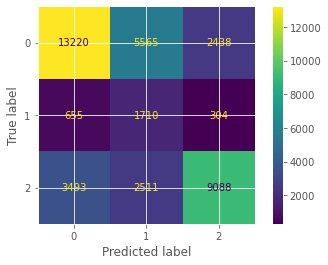

In [197]:
# Confusion matrix for trainig data
plot_confusion_matrix(best_logreg, X_train_resampled, y_train_resampled)
plt.show()

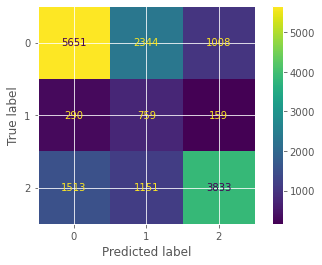

In [75]:
# Confusion matrix for testing data
plot_confusion_matrix(best_logreg, X_test_scaled, y_test_2)
plt.show()

In [198]:
# Predict on training and test sets
best_logreg_training_preds = best_logreg.predict(X_train_resampled)
best_logreg_preds = best_logreg.predict(X_test_scaled)


# Accuracy of training and test sets
best_logreg_training_accuracy = accuracy_score(y_train_resampled, best_logreg_training_preds)
best_logreg_test_accuracy = accuracy_score(y_test_2, best_logreg_preds)

print('Training Accuracy: {:.4}%'.format(best_logreg_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_logreg_test_accuracy * 100))

Training Accuracy: 62.54%
Validation accuracy: 61.08%


In [200]:
# validate logistic regression

#train cross validation
best_logreg_train_cv_score = cross_val_score(best_logreg, X_train_resampled,
                                        y_train_resampled, cv = 5, n_jobs = -1).mean()
print('Train cross validation:', best_logreg_train_cv_score)

#test cross validation
best_logreg_test_cv_score = cross_val_score(best_logreg, X_test_scaled, y_test_2,
                                       cv = 5, n_jobs = -1).mean()
print('Test cross validation:', best_logreg_test_cv_score)

Train cross validation: 0.624778234232209
Test cross validation: 0.621678057881594


The tuned logistic regression does not overfit but it doesn't meet our target thus we try another machine learning algorithm

### `RandomForestClassifier`

In [92]:
# Importing RandomForestClassifier library
from sklearn.ensemble import RandomForestClassifier

#### `RandomForestClassifier baseline model`

In [201]:
# instantiating RandomForestClassifier
RF = RandomForestClassifier()
# Fitting RandomForestClassifier
RF.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
RF_training_preds = RF.predict(X_train_resampled)
RF_test_preds = RF.predict(X_test_scaled)

# Accuracy of training and test sets
RF_training_accuracy = accuracy_score(y_train_resampled, RF_training_preds)
RF_test_accuracy = accuracy_score(y_test_2, RF_test_preds)

print('Training Accuracy: {:.4}%'.format(RF_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(RF_test_accuracy * 100))

Training Accuracy: 93.21%
Validation accuracy: 73.95%


This Random forest baseline model is overfitting the training data so we are going to do a grid search to get the best hyperparameters that would reduce overfitting.

In [202]:
# Creating a parameter grid
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']}

In [203]:
# Grid searching
RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5)
RF_CV.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200]})

In [204]:
# Getting the best hyperparameters for our RandomForestClassifier
RF_CV.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 200}

### Iterated random forest 

In [205]:
# Instantiating RandomForestClassifier model using the best parameters from the grid search
best_forest = RandomForestClassifier(criterion = 'entropy',max_depth = 6, max_features= 'sqrt',
                                     n_estimators = 200)

In [206]:
# Fitting the model
best_forest.fit(X_train_scaled,y_train_2)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200)

#### Evaluating random forest model

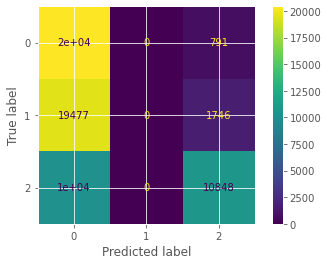

In [210]:
# Confusion matrix for trainig data
plot_confusion_matrix(best_forest, X_train_resampled, y_train_resampled)
plt.show()

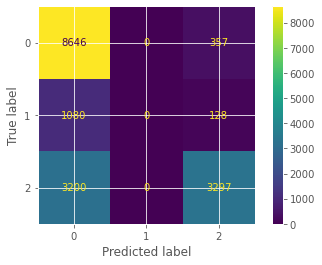

In [211]:
# Confusion matrix for testing data
plot_confusion_matrix(best_forest, X_test_scaled, y_test_2)
plt.show()

In [213]:
# Predict on training and test sets
best_forest_training_preds = best_forest.predict(X_train_resampled)
best_forest_preds = best_forest.predict(X_test_scaled)


# Accuracy of training and test sets
best_forest_training_accuracy = accuracy_score(y_train_resampled, best_forest_training_preds)
best_forest_test_accuracy = accuracy_score(y_test_2, best_forest_preds)

print('Training Accuracy: {:.4}%'.format(best_forest_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_forest_test_accuracy * 100))

Training Accuracy: 49.13%
Validation accuracy: 71.48%


In [214]:
# validate RandomForest regressor

#train cross validation
best_forest_train_cv_score = cross_val_score(best_forest, X_train_resampled,
                                        y_train_resampled, cv = 5, n_jobs = -1).mean()
print('Train cross validation:', best_forest_train_cv_score)

#test cross validation
best_forest_test_cv_score = cross_val_score(best_forest, X_test_scaled, y_test_2,
                                       cv = 5, n_jobs = -1).mean()
print('Test cross validation:', best_forest_test_cv_score)

Train cross validation: 0.6615150266227715
Test cross validation: 0.7153461222312559


The hyperparameter tuned random forest model seems to underfit the training data therefore we will use another machine learning algorithm.

### `KNeighborsClassifier`

In [215]:
# Importing KNeighborsClassifier library
from sklearn.neighbors import KNeighborsClassifier

In [218]:
#instantiate baseline model
knn_clf = KNeighborsClassifier()

#fit KNearest Neighbors
knn_clf.fit(X_train_resampled, y_train_resampled)

#predict on the test set
y_hat_train = knn_clf.predict(X_train_resampled)
y_hat_test = knn_clf.predict(X_test_scaled)

#train accuracy 
knn_train_accuracy = accuracy_score(y_train_resampled, y_hat_train) * 100
print('Train accuracy: {0}'.format(knn_train_accuracy))

#test accuracy 
knn_test_accuracy = accuracy_score(y_test_2, y_hat_test) * 100
print('Test accuracy: {0}'.format(knn_test_accuracy))

Train accuracy: 80.093923259357
Test accuracy: 71.15154417045727


KNeighborsClassifier baseline model seems to be slightly overfitting but the validation accuracy is within our target range.

We will try another model to see if we can reduce overfitting.

In [243]:
# set param grid
knn_param_grid = {"n_neighbors" : [3, 5, 7, 10],
                 'weights' : ['uniform', 'distance']}

# gridsearch
knn_gridsearch = GridSearchCV(estimator = knn_clf,
                            param_grid = knn_param_grid,
                            scoring = 'accuracy', cv = 5,
                            n_jobs = -1)

# fitting
knn_gridsearch.fit(X_train_resampled, y_train_resampled)

# Getting the best hyperparameters for our KNeighborsClassifier
knn_gridsearch.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

### Iterated KNeighborsClassifier

In [245]:
# Instantiating KNeighborsClassifier model using the best parameters from the grid search

best_knn = KNeighborsClassifier(n_neighbors = 5, weights = "distance")

# Fitting the model
best_knn.fit(X_train_resampled,y_train_resampled)

KNeighborsClassifier(weights='distance')

#### Evaluating KNeighborsClassifier

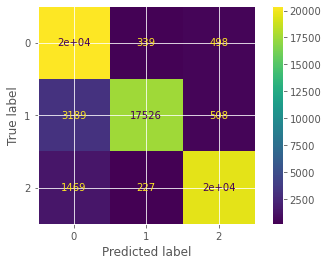

In [251]:
# Confusion matrix for trainig data
plot_confusion_matrix(best_knn, X_train_resampled, y_train_resampled)
plt.show()

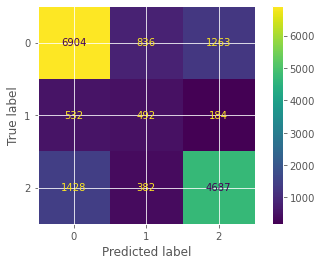

In [252]:
# Confusion matrix for testing data
plot_confusion_matrix(best_knn, X_test_scaled, y_test_2)
plt.show()

In [253]:
# Predict on training and test sets
best_knn_training_preds = best_knn.predict(X_train_resampled)
best_knn_preds = best_knn.predict(X_test_scaled)


# Accuracy of training and test sets
best_knn_training_accuracy = accuracy_score(y_train_resampled, best_knn_training_preds)
best_knn_test_accuracy = accuracy_score(y_test_2, best_knn_preds)

print('Training Accuracy: {:.4}%'.format(best_knn_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_knn_test_accuracy * 100))

Training Accuracy: 90.22%
Validation accuracy: 72.32%


In [254]:
# validate KNeighborsClassifier

#train cross validation
best_knn_train_cv_score = cross_val_score(best_knn, X_train_resampled,
                                        y_train_resampled, cv = 5, n_jobs = -1).mean()
print('Train cross validation:', best_knn_train_cv_score)

#test cross validation
best_knn_test_cv_score = cross_val_score(best_knn, X_test_scaled, y_test_2,
                                       cv = 5, n_jobs = -1).mean()
print('Test cross validation:', best_knn_test_cv_score)

Train cross validation: 0.7555643730654845
Test cross validation: 0.7300687592684044


The hyperparameter tuned KNeighborsClassifier seems to be overfitting the training data, but the validation accuracy meets our target.

We will use another model to see if the overfitting will reduce.

### `Gradient Boosting Classifier`

In [234]:
# Importing GradientBoostingClassifier library
from sklearn.ensemble import GradientBoostingClassifier

In [269]:
#instantiate baseline model
gradient_boost_clf = GradientBoostingClassifier(random_state = 21)

# fitting GradientBoostingClassifier model
gradient_boost_clf.fit(X_train_resampled, y_train_resampled)

# predicting the y values
y_hat_train = gradient_boost_clf.predict(X_train_resampled)
y_hat_test = gradient_boost_clf.predict(X_test_scaled)

# train accuracy
gradient_boost_train_accuracy_baseline = accuracy_score(y_train_resampled, y_hat_train) * 100
print('Train accuracy: {0}'.format(gradient_boost_train_accuracy_baseline))

# test accuracy
gradient_boost_test_accuracy_baseline = accuracy_score(y_test_2, y_hat_test) * 100
print('Test accuracy: {0}'.format(gradient_boost_test_accuracy_baseline))

Train accuracy: 70.93876140665002
Test accuracy: 66.28561168302609


The GradientBoostingClassifier model seems to slightly overfit but it doesn't meet our target range.

Thus we will try to tune our hyperparameter to see if we can meet our target range.

In [270]:
# set param grid
gradient_boost_param_grid = {'learning_rate': [0.025, 0.05],
                            'subsample': [0.5, 1.0]}

#gridsearch
gradient_boost_gridsearch = GridSearchCV(estimator = gradient_boost_clf,
                                        param_grid = gradient_boost_param_grid, 
                                        scoring = 'accuracy',
                                        n_jobs = -1,
                                        cv = 5)

# fitting the model
gradient_boost_gridsearch.fit(X_train_resampled, y_train_resampled)

# best param
gradient_boost_gridsearch.best_params_

{'learning_rate': 0.05, 'subsample': 0.5}

In [271]:
#train a classifier with optimal values identified above
gradient_boost_clf = GradientBoostingClassifier(random_state = 21,
                                                max_depth = 40,
                                                max_features = 'auto',
                                                min_samples_leaf = 3,
                                                min_samples_split = 8,
                                                n_estimators = 100,
                                                learning_rate = 0.05,
                                                subsample = 0.5)
# fitting the model
gradient_boost_clf.fit(X_train_resampled, y_train_resampled)

#predict
y_hat_train = gradient_boost_clf.predict(X_train_resampled)
y_hat_test = gradient_boost_clf.predict(X_test_scaled)

#train accuracy
gradient_boost_train_accuracy = accuracy_score(y_train_resampled, y_hat_train) * 100
print('Train accuracy: {0}'.format(gradient_boost_train_accuracy))

#test accuracy
gradient_boost_test_accuracy = accuracy_score(y_test_2, y_hat_test) * 100
print('Test accuracy: {0}'.format(gradient_boost_test_accuracy))

Train accuracy: 93.02329234007131
Test accuracy: 74.35360306440029


In [272]:
print("Logistic regression baseline model","\n")
print('Training Accuracy: {:.4}%'.format(log_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(log_test_accuracy * 100),"\n")
print("Tuned Logistic regression","\n")
print('Training Accuracy: {:.4}%'.format(best_logreg_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_logreg_test_accuracy * 100),"\n")
print("Random Forest baseline model","\n")
print('Training Accuracy: {:.4}%'.format(RF_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(RF_test_accuracy * 100),"\n")
print("Tuned Random Forest ","\n")
print('Training Accuracy: {:.4}%'.format(best_forest_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_forest_test_accuracy * 100),"\n")
print("KNearestNeighbors baseline model ","\n")
print('Train accuracy: {0}'.format(knn_train_accuracy))
print('Test accuracy: {0}'.format(knn_test_accuracy),"\n")
print("Tuned KNeighborsClassifier","\n")
print('Training Accuracy: {:.4}%'.format(best_knn_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_knn_test_accuracy * 100),"\n")
print("GradientBoostingClassifier Baseline model","\n")
print('Train accuracy: {0}'.format(gradient_boost_train_accuracy_baseline))
print('Test accuracy: {0}'.format(gradient_boost_test_accuracy_baseline),"\n")
print("Tuned GradientBoostingClassifier","\n")
print('Train accuracy: {0}'.format(gradient_boost_train_accuracy))
print('Test accuracy: {0}'.format(gradient_boost_test_accuracy))

Logistic regression baseline model 

Training Accuracy: 62.55%
Validation accuracy: 60.88% 

Tuned Logistic regression 

Training Accuracy: 62.54%
Validation accuracy: 61.08% 

Random Forest baseline model 

Training Accuracy: 93.21%
Validation accuracy: 73.95% 

Tuned Random Forest  

Training Accuracy: 49.13%
Validation accuracy: 71.48% 

KNearestNeighbors baseline model  

Train accuracy: 80.093923259357
Test accuracy: 71.15154417045727 

Tuned KNeighborsClassifier 

Training Accuracy: 90.22%
Validation accuracy: 72.32% 

GradientBoostingClassifier Baseline model 

Train accuracy: 70.93876140665002
Test accuracy: 66.28561168302609 

Tuned GradientBoostingClassifier 

Train accuracy: 93.02329234007131
Test accuracy: 74.35360306440029


## Evaluation and interpretation of the best model
The best overall model is the KNeighborsClassifier baseline model. This model has an accuracy of 71% on the testing data. This implies that if a class is predicted as functional this will be correct 71% of the time. This model was selected because it didn't have the highest training accuracy nor validation accuracy score it had the most minor difference between the training and the validation accuracy therefore the model will not perform very poorly when unseen data is used. It is the least overfitting model that meets our success criteria.